In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob, os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, activations, optimizers, losses, metrics, initializers
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.applications import MobileNetV3Small, MobileNet, InceptionV3
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input, decode_predictions

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
!pip install opendatasets --upgrade
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: pinky1234
Your Kaggle Key: ··········


100%|██████████| 195M/195M [00:01<00:00, 187MB/s]


In [3]:
data_dir = '/content/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/'

In [4]:
def prepare_image(file):
    img = image.load_img(file, target_size=(128,128))
    img_array = image.img_to_array(img)
    return tf.keras.applications.efficientnet.preprocess_input (img_array)

In [5]:
directories = os.listdir(data_dir) # read the folders

files = [] # save all images for each folder
labels = [] # set for each image the name of it

# read files for each directory
for folder in directories:
    
    fileList = glob.glob(data_dir + '/'+ folder + '/*')
    labels.extend([folder for l in fileList])
    files.extend(fileList)
    
len(files), len(labels)

(1578, 1578)

In [6]:
selected_files = []
selected_labels = []

for file, label in zip(files, labels):
    if 'mask' in file:
        selected_files.append(file)
        selected_labels.append(label)

    
len(selected_files), len(selected_labels)

(798, 798)

In [7]:
images = {
    'image': [], 
    'target': []
}

print('Preparing the image...')

for i, (file, label) in enumerate(zip(selected_files, selected_labels)):
    images['image'].append(prepare_image(file))
    images['target'].append(label)

Preparing the image...


In [8]:
images['image'] = np.array(images['image'])
images['target'] = np.array(images['target'])

# encode the target
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

images['target'] = le.fit_transform(images['target'])

classes = le.classes_ # get the classes for each target
print(f'the target classes are: {classes}')

the target classes are: ['benign' 'malignant' 'normal']


In [9]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(images['image'], images['target'], test_size=.10)

x_train.shape, x_test.shape, y_train.shape, y_test.shape 

((718, 128, 128, 3), (80, 128, 128, 3), (718,), (80,))

In [10]:
from tensorflow.keras.applications import EfficientNetB7
base_model = EfficientNetB7(
    include_top=False,
    weights='imagenet',
    input_shape=(128,128, 3),
    classes=3)

# Freeze the base_model
base_model.trainable = False

# append my own layers on the top of the model for Transfer Learning
x = base_model.output

# 1st conv block
x = layers.Conv2D(256, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.GlobalAveragePooling2D(keepdims = True)(x)

# 2nd conv block
x = layers.Conv2D(128, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.GlobalAveragePooling2D(keepdims = True)(x)

# 1st FC layer
x = layers.Flatten()(x) 
x = layers.Dense(64)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

# 2nd FC layer
x = layers.Dense(32, activation = 'relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(.2)(x)

x = layers.Dense(3, 'softmax')(x)

incept_model = keras.models.Model(inputs = base_model.input, outputs = x)

# compile the model
incept_model.compile(optimizer=optimizers.RMSprop(.001), loss = losses.sparse_categorical_crossentropy, metrics= [metrics.SparseCategoricalAccuracy()])

258088960/258076736 [==============================] - 2s 0us/step


In [11]:
earlyStop = keras.callbacks.EarlyStopping(patience=60) 
best_model = keras.callbacks.ModelCheckpoint(filepath='best_model.h5', save_best_only=True) 

with tf.device('/gpu:0'):
    history = incept_model.fit(x_train, y_train, batch_size=32, epochs=200, validation_data=(x_test, y_test), callbacks=[earlyStop, best_model])

Epoch 1/200
23/23 [==============================] - 60s 880ms/step - loss: 0.7244 - sparse_categorical_accuracy: 0.7242 - val_loss: 1.0579 - val_sparse_categorical_accuracy: 0.4125
Epoch 2/200
23/23 [==============================] - 11s 497ms/step - loss: 0.3956 - sparse_categorical_accuracy: 0.8955 - val_loss: 0.9491 - val_sparse_categorical_accuracy: 0.5500
Epoch 3/200
23/23 [==============================] - 11s 468ms/step - loss: 0.3306 - sparse_categorical_accuracy: 0.9109 - val_loss: 0.8360 - val_sparse_categorical_accuracy: 0.5500
Epoch 4/200
23/23 [==============================] - 8s 362ms/step - loss: 0.2983 - sparse_categorical_accuracy: 0.9276 - val_loss: 0.8903 - val_sparse_categorical_accuracy: 0.5500
Epoch 5/200
23/23 [==============================] - 11s 487ms/step - loss: 0.2634 - sparse_categorical_accuracy: 0.9123 - val_loss: 0.6892 - val_sparse_categorical_accuracy: 0.5875
Epoch 6/200
23/23 [==============================] - 8s 362ms/step - loss: 0.2669 - sparse_

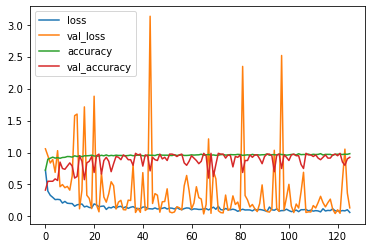

In [12]:
hist = history.history

plt.plot(hist['loss'], label=  'loss')
plt.plot(hist['val_loss'], label = 'val_loss')
plt.plot(hist['sparse_categorical_accuracy'], label='accuracy')
plt.plot(hist['val_sparse_categorical_accuracy'], label='val_accuracy')
plt.legend()

In [13]:
def predict_image(img_path, label):
    img1 = prepare_image(img_path) # preprocess the image
    res = incept_model.predict(np.expand_dims(img1, axis = 0)) # predict the image
    pred = classes[np.argmax(res)]

    # Visualize the image
    img = image.load_img(img_path)
    plt.imshow(np.array(img))
    plt.title(f'True: {label}\nPredicted: {pred}')

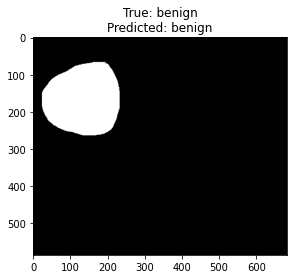

In [14]:
predict_image(data_dir + 'benign/benign (10)_mask.png', 'benign')

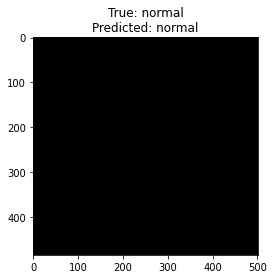

In [15]:
predict_image(data_dir + 'normal/normal (10)_mask.png', 'normal')

# VGG 16

In [16]:
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path

In [17]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
  conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
  if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
  else:
    for layer in conv_base.layers:
      layer.trainable = False
  top_model = conv_base.output
  top_model = Flatten(name="flatten")(top_model)
  top_model = Dense(4096, activation='relu')(top_model)
  top_model = Dense(1072, activation='relu')(top_model)
  top_model = Dropout(0.2)(top_model)
  output_layer = Dense(n_classes, activation='softmax')(top_model)
  model = Model(inputs=conv_base.input, outputs=output_layer)
  model.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
  return model

In [18]:
BATCH_SIZE = 64

In [19]:
from keras.losses import categorical_crossentropy
#from keras.layers import Activation, BatchNormalization, Conv2D, Dense, Flatten, MaxPooling2D
from keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.applications import densenet, inception_v3, mobilenet, resnet50, vgg16, vgg19, xception
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from keras import regularizers
from tensorflow.keras.utils import to_categorical as keras_to_categorical

In [20]:
input_shape = (128,128, 3)
optim_1 = optimizers.RMSprop(.001)
n_classes=3
optim_2 = Adam(learning_rate=0.001)
n_epochs = 50
vgg_model = create_model(input_shape, n_classes, optim_1, fine_tune=0)
vgg_model1 = create_model(input_shape, n_classes, optim_2, fine_tune=0)

58900480/58889256 [==============================] - 0s 0us/step


In [21]:
best_model1 = ModelCheckpoint(filepath='vgg_bc.h5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

In [22]:
best_model2 = ModelCheckpoint(filepath='vgg_bcA.h5',
                                  save_best_only=True,
                                  verbose=1)


In [23]:
with tf.device('/gpu:0'):
    history1 = vgg_model.fit(x_train, y_train, batch_size=64, epochs=200, validation_data=(x_test, y_test), callbacks=[early_stop,best_model1])

Epoch 1/200
12/12 [==============================] - ETA: 0s - loss: 115.2907 - accuracy: 0.7911
Epoch 1: val_loss improved from inf to 70.72515, saving model to vgg_bc.h5
12/12 [==============================] - 12s 727ms/step - loss: 115.2907 - accuracy: 0.7911 - val_loss: 70.7252 - val_accuracy: 0.4875
Epoch 2/200
12/12 [==============================] - ETA: 0s - loss: 10.6829 - accuracy: 0.9220
Epoch 2: val_loss improved from 70.72515 to 0.00004, saving model to vgg_bc.h5
12/12 [==============================] - 4s 376ms/step - loss: 10.6829 - accuracy: 0.9220 - val_loss: 3.7017e-05 - val_accuracy: 1.0000
Epoch 3/200
12/12 [==============================] - ETA: 0s - loss: 1.8759 - accuracy: 0.9582
Epoch 3: val_loss improved from 0.00004 to 0.00000, saving model to vgg_bc.h5
12/12 [==============================] - 4s 315ms/step - loss: 1.8759 - accuracy: 0.9582 - val_loss: 1.4901e-09 - val_accuracy: 1.0000
Epoch 4/200
12/12 [==============================] - ETA: 0s - loss: 0.313

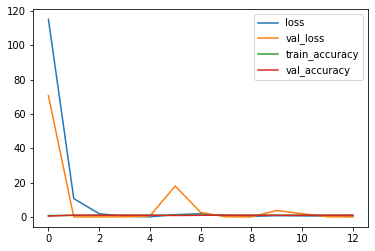

In [27]:
hist1 = history1.history

plt.plot(hist1['loss'], label=  'loss')
plt.plot(hist1['val_loss'], label = 'val_loss')
plt.plot(hist1['accuracy'], label='train_accuracy')
plt.plot(hist1['val_accuracy'], label='val_accuracy')
plt.legend()

In [28]:
def predict_image1(img_path, label):
    img1 = prepare_image(img_path) # preprocess the image
    res = vgg_model.predict(np.expand_dims(img1, axis = 0)) # predict the image
    pred = classes[np.argmax(res)]

    # Visualize the image
    img = image.load_img(img_path)
    plt.imshow(np.array(img))
    plt.title(f'True: {label}\nPredicted: {pred}')

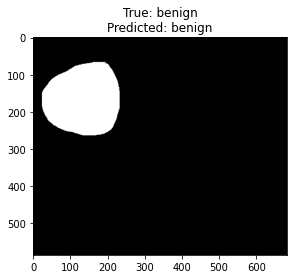

In [29]:
predict_image1(data_dir + 'benign/benign (10)_mask.png', 'benign')

In [30]:
with tf.device('/gpu:0'):
    history2 = vgg_model1.fit(x_train, y_train, batch_size=32, epochs=200, validation_data=(x_test, y_test), callbacks=[early_stop,best_model2])

Epoch 1/200
23/23 [==============================] - ETA: 0s - loss: 0.0438 - accuracy: 0.9986
Epoch 10: val_loss did not improve from 0.00000
23/23 [==============================] - 3s 120ms/step - loss: 0.0438 - accuracy: 0.9986 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 11/200
23/23 [==============================] - ETA: 0s - loss: 0.0505 - accuracy: 0.9958
Epoch 11: val_loss did not improve from 0.00000
23/23 [==============================] - 3s 120ms/step - loss: 0.0505 - accuracy: 0.9958 - val_loss: 6.5496e-04 - val_accuracy: 1.0000
Epoch 12/200
23/23 [==============================] - ETA: 0s - loss: 0.0611 - accuracy: 0.9958
Epoch 12: val_loss did not improve from 0.00000
23/23 [==============================] - 3s 121ms/step - loss: 0.0611 - accuracy: 0.9958 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 13/200
23/23 [==============================] - ETA: 0s - loss: 0.0352 - accuracy: 0.9972
Epoch 13: val_loss did not improve from 0.00000
23/23 [=============

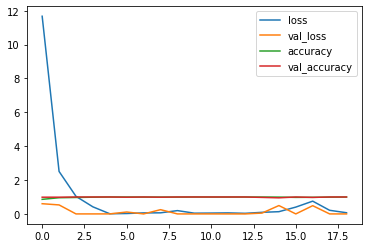

In [32]:
hist2 = history2.history

plt.plot(hist2['loss'], label=  'loss')
plt.plot(hist2['val_loss'], label = 'val_loss')
plt.plot(hist2['accuracy'], label='accuracy')
plt.plot(hist2['val_accuracy'], label='val_accuracy')
plt.legend()

# MobileNet

In [39]:
IMG_SHAPE = (128,128,3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [40]:
best_model3 = ModelCheckpoint(filepath='best_modelmo.h5',
                                  save_best_only=True,
                                  verbose=1)

In [42]:
base_model.trainable = False
model = tf.keras.Sequential([
                          base_model,
                          keras.layers.GlobalAveragePooling2D(),
                          keras.layers.Dense(3, activation='sigmoid')])

In [45]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.01),
              loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [48]:
history3 = model.fit(x_train, y_train, batch_size=32, epochs=200, validation_data=(x_test, y_test), callbacks=[early_stop,best_model])

Epoch 1/200
23/23 [==============================] - 6s 112ms/step - loss: 1.1966 - accuracy: 0.8050 - val_loss: 0.8138 - val_accuracy: 0.7125
Epoch 2/200
23/23 [==============================] - 1s 41ms/step - loss: 0.2771 - accuracy: 0.9192 - val_loss: 0.0760 - val_accuracy: 0.9625
Epoch 3/200
23/23 [==============================] - 1s 38ms/step - loss: 0.1780 - accuracy: 0.9499 - val_loss: 4.1918 - val_accuracy: 0.4625
Epoch 4/200
23/23 [==============================] - 1s 42ms/step - loss: 0.3539 - accuracy: 0.9331 - val_loss: 0.0758 - val_accuracy: 0.9875
Epoch 5/200
23/23 [==============================] - 1s 41ms/step - loss: 0.1697 - accuracy: 0.9582 - val_loss: 0.4145 - val_accuracy: 0.9250
Epoch 6/200
23/23 [==============================] - 1s 40ms/step - loss: 0.2486 - accuracy: 0.9429 - val_loss: 0.1244 - val_accuracy: 0.9750
Epoch 7/200
23/23 [==============================] - 1s 37ms/step - loss: 0.1140 - accuracy: 0.9721 - val_loss: 0.1783 - val_accuracy: 0.9625
Epoch

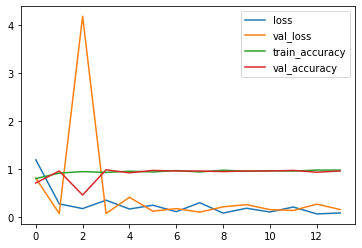

In [49]:
hist3 = history3.history

plt.plot(hist3['loss'], label=  'loss')
plt.plot(hist3['val_loss'], label = 'val_loss')
plt.plot(hist3['accuracy'], label='train_accuracy')
plt.plot(hist3['val_accuracy'], label='val_accuracy')
plt.legend()